In [13]:
!pip install xgboost 


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 13.8 MB/s eta 0:00:0000:0100:01


MULTI-METHOD ANOMALY DETECTION - REAL-TIME TEST

Fetching 24-hour Vancouver forecast...

Weather Summary:
  Temp Range: 9.4C - 13.3C
  Max Precipitation: 0.0 mm
  Max Wind: 8.4 km/h

Predicting delivery demand...
  Demand Range: 112.8 - 151.1

Running anomaly detection methods...

ANOMALY DETECTION SUMMARY

Method               Anomalies    Hours Flagged                 
Z-Score              0            []                            
Isolation Forest     3            [12, 13, 14]                  
LOF                  3            [11, 12, 14]                  
One-Class SVM        4            [0, 12, 21, 23]               

CONSENSUS ANALYSIS

Hour 00: [LOW] 1/4 methods agree | Demand: 118.1
Hour 11: [LOW] 1/4 methods agree | Demand: 150.3
Hour 12: [HIGH] 3/4 methods agree | Demand: 151.1
Hour 13: [LOW] 1/4 methods agree | Demand: 150.2
Hour 14: [MEDIUM] 2/4 methods agree | Demand: 118.8
Hour 21: [LOW] 1/4 methods agree | Demand: 112.8
Hour 23: [LOW] 1/4 methods agree | Demand: 115.

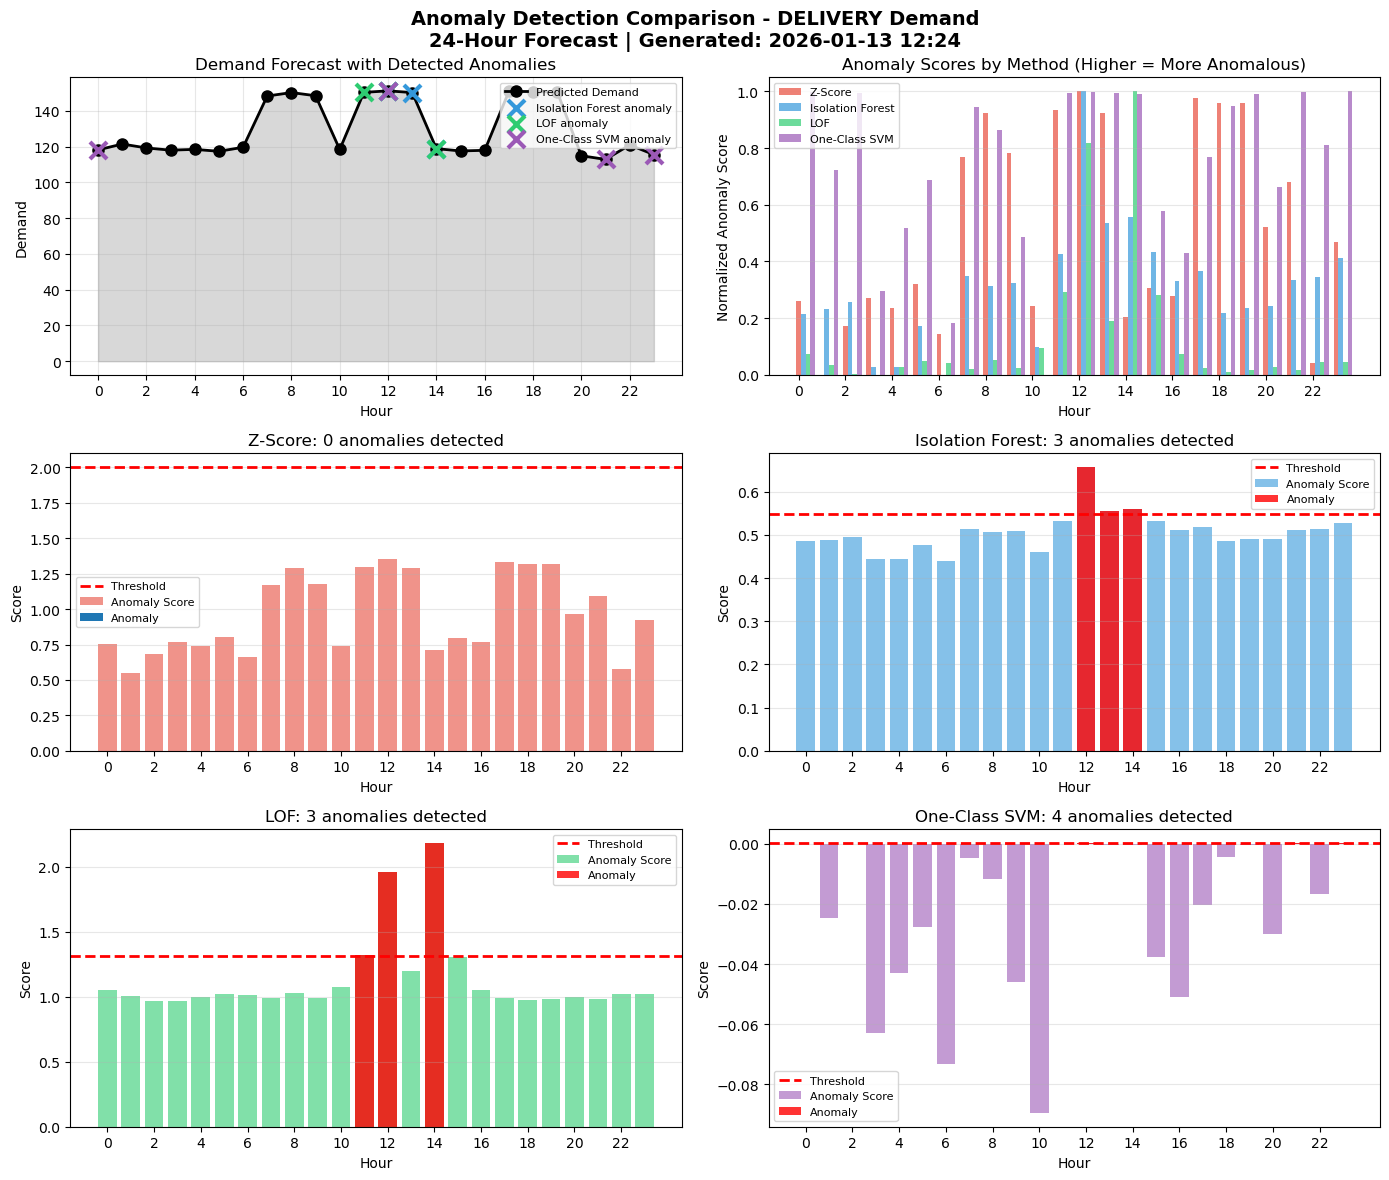

In [30]:
import requests
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler


def get_vancouver_forecast():
    """Fetch 24-hour forecast for Vancouver"""
    url = "https://api.open-meteo.com/v1/forecast"
    params = {
        "latitude": 49.2827,
        "longitude": -123.1207,
        "hourly": [
            "temperature_2m", "relative_humidity_2m", "precipitation",
            "snowfall", "rain", "wind_speed_10m", "cloud_cover", "is_day"
        ],
        "timezone": "America/Vancouver",
        "forecast_days": 1
    }
    
    response = requests.get(url, params=params)
    data = response.json()
    hourly = data["hourly"]
    records = []
    
    for i in range(24):
        hour = i
        day_of_week = datetime.now().weekday()
        month = datetime.now().month
        
        records.append({
            "temperature": hourly["temperature_2m"][i],
            "humidity": hourly["relative_humidity_2m"][i],
            "precipitation": hourly["precipitation"][i],
            "snowfall": hourly["snowfall"][i],
            "wind_speed": hourly["wind_speed_10m"][i],
            "cloud_cover": hourly["cloud_cover"][i],
            "is_day": hourly["is_day"][i],
            "hour": hour,
            "day_of_week": day_of_week,
            "month": month,
            "daylight_duration": 9.5,
            "bad_weather_combo": int(hourly["rain"][i] > 2 and hourly["wind_speed_10m"][i] > 20),
            "is_peak_hour": get_peak_hour(hour, day_of_week),
            "season": get_season(month)
        })
    
    return pd.DataFrame(records)


def get_season(month):
    if month in [12, 1, 2]: return 0
    elif month in [3, 4, 5]: return 1
    elif month in [6, 7, 8]: return 2
    else: return 3


def get_peak_hour(hour, day_of_week):
    if day_of_week < 5:
        return int(hour in [7, 8, 9, 11, 12, 13, 17, 18, 19])
    else:
        return int(hour in [10, 11, 12, 13, 14, 18, 19, 20])


def predict_demand(weather_df, model_path, domain):
    """Predict demand for all 24 hours"""
    feature_cols = [
        'temperature', 'humidity', 'precipitation', 'snowfall', 'wind_speed',
        'cloud_cover', 'is_day', 'hour', 'day_of_week', 'month',
        'daylight_duration', 'bad_weather_combo', 'is_peak_hour', 'season'
    ]
    
    X = weather_df[feature_cols]
    model = joblib.load(f"{model_path}{domain}_xgb.pkl")
    predictions = model.predict(X)
    
    return predictions


def detect_anomalies_all_methods(demands, weather_df):
    """Run 4 different anomaly detection methods"""
    feature_cols = ['temperature', 'humidity', 'precipitation', 'wind_speed', 
                    'cloud_cover', 'hour', 'is_peak_hour', 'season']
    X = weather_df[feature_cols].copy()
    X['demand'] = demands
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    results = {}
    
    # Z-Score
    mean, std = demands.mean(), demands.std()
    z_scores = np.abs((demands - mean) / std)
    results['Z-Score'] = {
        'scores': z_scores,
        'anomalies': z_scores > 2,
        'threshold': 2
    }
    
    # Isolation Forest
    iso = IsolationForest(contamination=0.1, random_state=42)
    iso_pred = iso.fit_predict(X_scaled)
    iso_scores = -iso.score_samples(X_scaled)
    results['Isolation Forest'] = {
        'scores': iso_scores,
        'anomalies': iso_pred == -1,
        'threshold': np.percentile(iso_scores, 90)
    }
    
    # Local Outlier Factor
    lof = LocalOutlierFactor(n_neighbors=5, contamination=0.1)
    lof_pred = lof.fit_predict(X_scaled)
    lof_scores = -lof.negative_outlier_factor_
    results['LOF'] = {
        'scores': lof_scores,
        'anomalies': lof_pred == -1,
        'threshold': np.percentile(lof_scores, 90)
    }
    
    # One-Class SVM
    ocsvm = OneClassSVM(nu=0.1, kernel='rbf', gamma='auto')
    ocsvm_pred = ocsvm.fit_predict(X_scaled)
    ocsvm_scores = -ocsvm.decision_function(X_scaled)
    results['One-Class SVM'] = {
        'scores': ocsvm_scores,
        'anomalies': ocsvm_pred == -1,
        'threshold': np.percentile(ocsvm_scores, 90)
    }
    
    return results


def plot_anomaly_comparison(hours, demands, results, domain):
    """Generate comparison plot of anomaly detection methods"""
    fig, axes = plt.subplots(3, 2, figsize=(14, 12))
    
    timestamp = datetime.now().strftime("%Y-%m-%d %H:%M")
    fig.suptitle(f'Anomaly Detection Comparison - {domain.upper()} Demand\n24-Hour Forecast | Generated: {timestamp}', 
                 fontsize=14, fontweight='bold')
    
    colors = {'Z-Score': '#e74c3c', 'Isolation Forest': '#3498db', 
              'LOF': '#2ecc71', 'One-Class SVM': '#9b59b6'}
    
    ax1 = axes[0, 0]
    ax1.plot(hours, demands, 'ko-', linewidth=2, markersize=8, label='Predicted Demand')
    ax1.fill_between(hours, demands, alpha=0.3, color='gray')
    
    for method, data in results.items():
        anomaly_mask = data['anomalies']
        if anomaly_mask.any():
            ax1.scatter(hours[anomaly_mask], demands[anomaly_mask], 
                       s=150, c=colors[method], marker='x', linewidths=3,
                       label=f'{method} anomaly', zorder=5)
    
    ax1.set_xlabel('Hour')
    ax1.set_ylabel('Demand')
    ax1.set_title('Demand Forecast with Detected Anomalies')
    ax1.legend(loc='upper right', fontsize=8)
    ax1.grid(True, alpha=0.3)
    ax1.set_xticks(range(0, 24, 2))
    
    ax2 = axes[0, 1]
    width = 0.2
    for i, (method, data) in enumerate(results.items()):
        scores = data['scores']
        norm_scores = (scores - scores.min()) / (scores.max() - scores.min() + 1e-10)
        ax2.bar(np.arange(24) + i*width, norm_scores, width, label=method, color=colors[method], alpha=0.7)
    
    ax2.set_xlabel('Hour')
    ax2.set_ylabel('Normalized Anomaly Score')
    ax2.set_title('Anomaly Scores by Method (Higher = More Anomalous)')
    ax2.legend(fontsize=8)
    ax2.set_xticks(range(0, 24, 2))
    ax2.grid(True, alpha=0.3, axis='y')
    
    method_list = list(results.keys())
    for idx, method in enumerate(method_list):
        row, col = (idx // 2) + 1, idx % 2
        ax = axes[row, col]
        data = results[method]
        scores, anomalies, threshold = data['scores'], data['anomalies'], data['threshold']
        
        ax.bar(hours, scores, color=colors[method], alpha=0.6, label='Anomaly Score')
        ax.axhline(y=threshold, color='red', linestyle='--', linewidth=2, label='Threshold')
        ax.bar(hours[anomalies], scores[anomalies], color='red', alpha=0.8, label='Anomaly')
        
        ax.set_xlabel('Hour')
        ax.set_ylabel('Score')
        ax.set_title(f'{method}: {anomalies.sum()} anomalies detected')
        ax.legend(fontsize=8)
        ax.grid(True, alpha=0.3, axis='y')
        ax.set_xticks(range(0, 24, 2))
    
    plt.tight_layout()
    plt.show()
    return fig


def print_summary(hours, demands, results):
    """Print anomaly detection summary and consensus analysis"""
    print("\nANOMALY DETECTION SUMMARY\n")
    print(f"{'Method':<20} {'Anomalies':<12} {'Hours Flagged':<30}")
    
    for method, data in results.items():
        anomalies = data['anomalies']
        flagged = list(hours[anomalies])
        print(f"{method:<20} {anomalies.sum():<12} {str(flagged):<30}")
    
    print("\nCONSENSUS ANALYSIS\n")
    
    all_anomalies = np.stack([data['anomalies'] for data in results.values()])
    agreement = all_anomalies.sum(axis=0)
    
    for hour in range(24):
        if agreement[hour] > 0:
            n = agreement[hour]
            label = "HIGH" if n >= 3 else "MEDIUM" if n >= 2 else "LOW"
            print(f"Hour {hour:02d}: [{label}] {n}/4 methods agree | Demand: {demands[hour]:.1f}")
    
    print("\nRECOMMENDATION\n")
    
    high_conf = np.where(agreement >= 3)[0]
    if len(high_conf) > 0:
        print(f"HIGH CONFIDENCE anomalies (3+ methods agree): Hours {list(high_conf)}")
    else:
        print("No high-confidence anomalies detected")


if __name__ == "__main__":
    MODEL_PATH = "/Users/cgp/Portfolio/WeatherDemand/wede/Weather_Models/"
    DOMAIN = "delivery"  # Options: delivery, energy, retail, ecommerce
    
    print("MULTI-METHOD ANOMALY DETECTION - REAL-TIME TEST\n")
    
    print("Fetching 24-hour Vancouver forecast...")
    weather_df = get_vancouver_forecast()
    
    print(f"\nWeather Summary:")
    print(f"  Temp Range: {weather_df['temperature'].min():.1f}C - {weather_df['temperature'].max():.1f}C")
    print(f"  Max Precipitation: {weather_df['precipitation'].max():.1f} mm")
    print(f"  Max Wind: {weather_df['wind_speed'].max():.1f} km/h")
    
    print(f"\nPredicting {DOMAIN} demand...")
    demands = np.array(predict_demand(weather_df, MODEL_PATH, DOMAIN))
    hours = np.arange(24)
    print(f"  Demand Range: {demands.min():.1f} - {demands.max():.1f}")
    
    print("\nRunning anomaly detection methods...")
    results = detect_anomalies_all_methods(demands, weather_df)
    
    print_summary(hours, demands, results)
    
    print("\nGenerating visualization...")
    plot_anomaly_comparison(hours, demands, results, DOMAIN)

In [21]:
import joblib
model = joblib.load("/Users/cgp/Portfolio/WeatherDemand/wede/Weather_Models/delivery_xgb.pkl")
print(model.get_booster().feature_names)

['temperature', 'humidity', 'precipitation', 'snowfall', 'wind_speed', 'cloud_cover', 'is_day', 'hour', 'day_of_week', 'month', 'daylight_duration', 'bad_weather_combo', 'is_peak_hour', 'season']
